# Export variables from a D-Eco Impact Ugrid NetCDF to the ESRI shapefile format

In [24]:
#load required libraries and prepare logging
import os
import sys
import xugrid as xu
import xarray as xr
import dfm_tools as dfmt  
sys.path.insert(1, '../library')
from DEcoImpact_exp_func import DEIOutput

In [28]:
#configuration

#list with input locations of D-Eco Impact export file that needs to be converted
list_ds_in = [r'../results/SpongeWorks/results_REACT_WFLOW_NearBottomFV_fishclasses_Vecht_2017_2023.nc']

# list with variables that need to be exported to shapefile. Note, these should only contain faces as axes (no time or depth etc).
rename_list_variabels = {'REACT_guilds_nearbottom' : 'guilds_NB',
                         'AVG_water_depth_m' : 'water_depth',
                         'nearbottom_flow_velocity_ms' : 'FlowVelNB',
                         'AVG_flow_velocity_ms' : 'AveFlowVel',
                         'REACT_guilds' : 'guilds_ADV',
                         }

#output path location for shapefile data created 
output_path = r'example_output_data/shapefile_output_NearBottomFV'

#make sure the folders to output path exist
if not os.path.exists(output_path):
    os.makedirs(output_path)

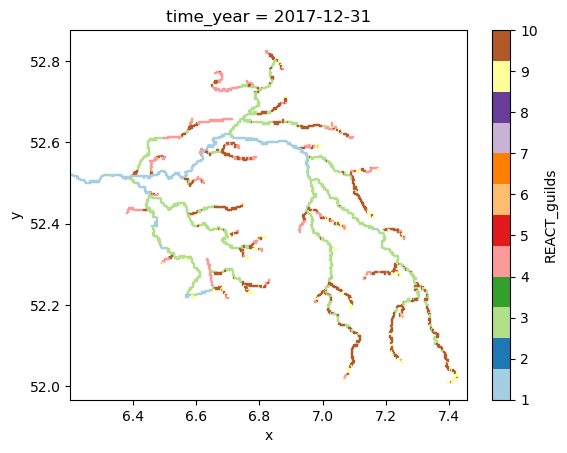

In [29]:
#Pre-visualize data with Xugrid
uda_map = xu.open_mfdataset(list_ds_in)
uda_map['REACT_guilds'].isel(time_year=0).ugrid.plot(cmap = "Paired")

In [30]:
#export a seperate Netcdf per year to convert to shapefile and adapt variable names so they fit the shapefile column
uda_map = uda_map.rename_vars(rename_list_variabels)
subsetted_uda_map = uda_map[list(rename_list_variabels.values())]

list_ds_in_per_year = []

#export a netcdf file per year calculated and store the path
for time_year_value in uda_map.time_year.values:
    time_subsetted_uda_map = subsetted_uda_map.sel(time_year = time_year_value)
    year = time_year_value.astype('datetime64[Y]').astype(int) + 1970
    file_path = "results/to_shape_results_REACT_WFLOW_NearBottomFV_fishclasses_Vecht_" + str(year) + ".nc"
    list_ds_in_per_year.append(file_path)
    time_subsetted_uda_map.ugrid.to_netcdf(file_path)

PermissionError: [Errno 13] Permission denied: 'c:\\Users\\flore_na\\OneDrive - Stichting Deltares\\Desktop\\PythonProjects\\D_EcoImpact\\D-EcoImpact\\postprocessing_SpongeWorks\\results\\to_shape_results_REACT_WFLOW_NearBottomFV_fishclasses_Vecht_2023.nc'

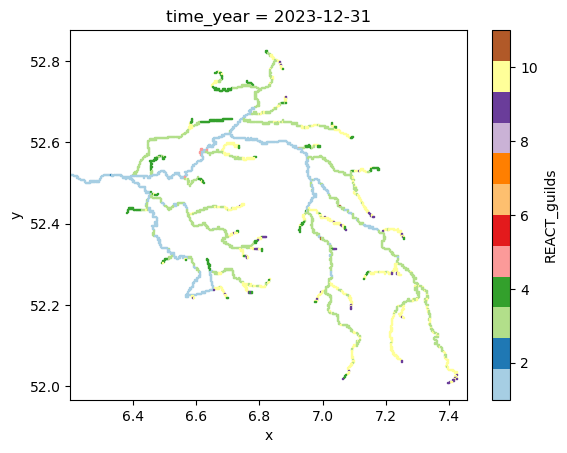

In [8]:
#read and show result
#Show result of one specific year for 
uda_map_test = xu.open_mfdataset(list_ds_in_per_year[-1])
uda_map_test["guilds_ADV"].ugrid.plot(cmap = "Paired")


In [16]:
#initialize
DEIresults = DEIOutput()
cwd = os.getcwd()
DEIresults.set_root(root = cwd)

#Add paths to the result NetCDF(s) 
DEIresults.set_paths_to_DEIresults(input_list_path = list_ds_in_per_year[0:])

#Export to Shapefile
DEIresults.translate_UgridNetCDFs_to_Shape(
    list_variables = list(rename_list_variabels.values()),
    output_path = output_path
)

print("Done.")

Shortened variable name 'water_depth' to 'water_dep
Start with results/to_shape_results_REACT_WFLOW_NearBottomFV_fishclasses_Vecht_2017.nc
Exported example_output_data/shapefile_output_NearBottomFV\to_shape_results_REACT_WFLOW_NearBottomFV_fishclasses_Vecht_2017
Start with results/to_shape_results_REACT_WFLOW_NearBottomFV_fishclasses_Vecht_2018.nc
Exported example_output_data/shapefile_output_NearBottomFV\to_shape_results_REACT_WFLOW_NearBottomFV_fishclasses_Vecht_2018
Start with results/to_shape_results_REACT_WFLOW_NearBottomFV_fishclasses_Vecht_2019.nc
Exported example_output_data/shapefile_output_NearBottomFV\to_shape_results_REACT_WFLOW_NearBottomFV_fishclasses_Vecht_2019
Start with results/to_shape_results_REACT_WFLOW_NearBottomFV_fishclasses_Vecht_2020.nc
Exported example_output_data/shapefile_output_NearBottomFV\to_shape_results_REACT_WFLOW_NearBottomFV_fishclasses_Vecht_2020
Start with results/to_shape_results_REACT_WFLOW_NearBottomFV_fishclasses_Vecht_2021.nc
Exported example_

In [19]:
def postprocess_from_shapefiles_only_with_counts(output_path):
    """
    Use existing per-year shapefiles (recursively found under output_path; ignores complete_file.shp)
    to compute guilds_ADV and guilds_NB summaries and certainty.

    Outputs (NO shapefile is written):
      - Per-year CSVs (one per variable):
          adv_area_by_class_per_year.csv
          nb_area_by_class_per_year.csv
        Columns: variable, prefix, year, class, count, area_m2, pct_area, assessed_area_m2

      - Per-face certainty CSVs (one per variable):
          adv_certainty_per_face.csv
          nb_certainty_per_face.csv
        Columns: face_id|row_index, yrs_seen, cert_class, cert_pct, cnt_01..cnt_13

      - Plots:
          adv_pct_area_stacked_by_year.png, nb_pct_area_stacked_by_year.png
          adv_area_m2_by_year.png,         nb_area_m2_by_year.png
          adv_certainty_distribution.png,  nb_certainty_distribution.png
          adv_dominant_class_area_share.png, nb_dominant_class_area_share.png

    Notes:
      - Assumes per-year shapefiles are from the same mesh and order; if a stable ID field exists
        (e.g., ugrid_fid / face / fid / index), it is used to align faces across years.
      - CRS is set to EPSG:4326 if missing and projected to EPSG:28992 for true area calculations.
    """
    import os, re, warnings
    import numpy as np
    import pandas as pd
    import geopandas as gpd
    import matplotlib.pyplot as plt

    VARIABLES = [("guilds_ADV", "adv"), ("guilds_NB", "nb")]
    CLASSES = list(range(1, 14))

    csv_out_pattern = "{prefix}_area_by_class_per_year.csv"
    csv_cert_pattern = "{prefix}_certainty_per_face.csv"
    png_stacked_pattern = "{prefix}_pct_area_stacked_by_year.png"
    png_lines_pattern   = "{prefix}_area_m2_by_year.png"
    png_cert_hist       = "{prefix}_certainty_distribution.png"
    png_dom_class_area  = "{prefix}_dominant_class_area_share.png"

    os.makedirs(output_path, exist_ok=True)

    # ---- 1) Find per-year shapefiles recursively (ignore 'complete_file.shp')
    year_to_paths = {}
    for root, _, files in os.walk(output_path):
        for f in files:
            if not f.lower().endswith(".shp"):
                continue
            if f == "complete_file.shp":
                continue
            m = re.search(r"(19|20)\d{2}", f)
            year = int(m.group(0)) if m else None
            if year is None:
                m2 = re.search(r"(19|20)\d{2}", os.path.basename(root))
                year = int(m2.group(0)) if m2 else None
            if year is None:
                continue
            year_to_paths.setdefault(year, []).append(os.path.join(root, f))

    if not year_to_paths:
        raise FileNotFoundError(f"No per-year shapefiles found under '{output_path}'")

    years = sorted(year_to_paths.keys())
    print(f"Found {len(years)} year(s): {years}")

    # ---- 2) Load per-year shapefiles; ensure EPSG:28992 and compute area
    per_year_gdf = {}
    for y in years:
        # choose a reasonable file if multiple; first is fine for DEI outputs
        shp = gpd.read_file(year_to_paths[y][0])
        if shp.crs is None:
            shp = shp.set_crs(4326)
        if shp.crs.to_epsg() != 28992:
            shp = shp.to_crs(28992)
        shp["area_m2"] = shp.geometry.area.astype("float64")
        per_year_gdf[y] = shp

    # Determine the guilds columns present (handle truncated names if needed per-year below)
    base_cols = set(per_year_gdf[years[0]].columns)

    # ---- Helper: pick the column name for a variable inside a shapefile (handles truncation)
    def pick_field(shp: gpd.GeoDataFrame, varname: str):
        import numpy as np
        candidates = []
        if varname in shp.columns:
            candidates.append(varname)
        lowmap = {c.lower(): c for c in shp.columns}
        if varname.lower() in lowmap:
            candidates.append(lowmap[varname.lower()])
        suffix = varname.split("_")[-1].lower()  # 'adv' or 'nb'
        for c in shp.columns:
            cl = c.lower()
            if ("guild" in cl) and (suffix in cl):
                candidates.append(c)
        # dedupe
        seen = set(); candidates = [x for x in candidates if not (x in seen or seen.add(x))]
        # validate looks like 1..13 or NaN
        for c in candidates:
            vals = pd.to_numeric(shp[c], errors="coerce").dropna().unique()
            if len(vals) == 0:
                return c
            arr = pd.to_numeric(pd.Series(vals), errors="coerce").dropna().values
            if arr.size and np.all((arr >= 1) & (arr <= 13) & (arr == np.floor(arr))):
                return c
        # last resort: any numeric-looking column 1..13
        for c in shp.select_dtypes(include=["number"]).columns:
            vals = pd.to_numeric(shp[c], errors="coerce").dropna().unique()
            if len(vals) == 0:
                continue
            arr = pd.to_numeric(pd.Series(vals), errors="coerce").dropna().values
            if arr.size and np.all((arr >= 1) & (arr <= 13) & (arr == np.floor(arr))):
                return c
        raise KeyError(f"Cannot identify field for '{varname}'. Columns: {list(shp.columns)}")

    # ---- Optional: attempt to find a stable face ID field across all years
    candidate_id_fields = ["ugrid_fid", "face", "fid", "index", "ID", "id", "FaceID", "FACE_ID"]
    face_id_field = None
    for cand in candidate_id_fields:
        ok = all((cand in per_year_gdf[y].columns) for y in years)
        if ok and all(per_year_gdf[y][cand].is_unique for y in years):
            face_id_field = cand
            break
    if face_id_field:
        print(f"Using stable face ID for alignment: '{face_id_field}'")
    else:
        warnings.warn("No stable face ID field detected; aligning faces by row order across years. "
                      "This assumes exporter preserved face ordering.")

    # ---- 3) Per-year stats (ADD: counts)
    for varname, prefix in VARIABLES:
        records = []
        for y in years:
            shp = per_year_gdf[y]
            field = pick_field(shp, varname)
            col = pd.to_numeric(shp[field], errors="coerce")
            valid = col.notna()
            assessed_area = shp.loc[valid, "area_m2"].sum()

            for c in CLASSES:
                sel = valid & (col == float(c))
                count_c = int(sel.sum())  # <<< NEW: count of faces
                area_c = float(shp.loc[sel, "area_m2"].sum())
                pct_area = float(100.0 * area_c / assessed_area) if assessed_area > 0 else 0.0
                records.append({
                    "variable": varname,
                    "prefix": prefix,
                    "year": int(y),
                    "class": int(c),
                    "count": count_c,                 # <<< included
                    "area_m2": area_c,
                    "pct_area": pct_area,
                    "assessed_area_m2": float(assessed_area),
                })

        df_yearly = pd.DataFrame.from_records(records).sort_values(["year", "class"])
        csv_out = os.path.join(output_path, csv_out_pattern.format(prefix=prefix))
        df_yearly.to_csv(csv_out, index=False)
        print(f"Wrote per-year area+count CSV for {varname}: {csv_out}")

        # Plots (unchanged)
        pivot_pct = (
            df_yearly.pivot(index="year", columns="class", values="pct_area")
            .reindex(columns=CLASSES)
            .fillna(0.0)
        )
        ax = pivot_pct.plot(kind="bar", stacked=True, figsize=(14, 6), cmap="tab20", width=0.85)
        ax.set_ylabel("% of assessed area")
        ax.set_xlabel("Year")
        ax.set_title(f"{varname}: percent area by class (1–13) per year")
        ax.legend(title="Class", bbox_to_anchor=(1.02, 1.0), loc="upper left", ncol=1, frameon=False)
        plt.tight_layout()
        png_out1 = os.path.join(output_path, png_stacked_pattern.format(prefix=prefix))
        plt.savefig(png_out1, dpi=200)
        plt.close()
        print(f"Wrote plot: {png_out1}")

        pivot_area = (
            df_yearly.pivot(index="year", columns="class", values="area_m2")
            .reindex(columns=CLASSES)
            .fillna(0.0)
        )
        ax = pivot_area.plot(kind="line", figsize=(14, 6), cmap="tab20", marker="o")
        ax.set_ylabel("Area (m²)")
        ax.set_xlabel("Year")
        ax.set_title(f"{varname}: area (m²) by class per year")
        ax.legend(title="Class", bbox_to_anchor=(1.02, 1.0), loc="upper left", ncol=1, frameon=False)
        plt.tight_layout()
        png_out2 = os.path.join(output_path, png_lines_pattern.format(prefix=prefix))
        plt.savefig(png_out2, dpi=200)
        plt.close()
        print(f"Wrote plot: {png_out2}")

    # ---- 4) Cross-year certainty per face (from shapefiles only)
    # Build per-variable, per-face matrix across years aligned by ID or row index
    def build_face_matrix(varname: str):
        ref_y = years[0]
        ref = per_year_gdf[ref_y]
        if face_id_field:
            ids = ref[face_id_field].copy()
            mats = []
            for y in years:
                shp = per_year_gdf[y]
                field = pick_field(shp, varname)
                df_pair = ref[[face_id_field]].merge(shp[[face_id_field, field]], on=face_id_field, how="left")
                mats.append(pd.to_numeric(df_pair[field], errors="coerce").to_numpy())
            vals = np.column_stack(mats).astype("float64")
            return vals, ids
        else:
            mats = []
            for y in years:
                shp = per_year_gdf[y]
                field = pick_field(shp, varname)
                mats.append(pd.to_numeric(shp[field], errors="coerce").to_numpy())
            vals = np.column_stack(mats).astype("float64")
            ids = pd.Series(np.arange(len(ref)), name="row_index")
            return vals, ids

    for varname, prefix in VARIABLES:
        vals, ids = build_face_matrix(varname)
        valid = ~np.isnan(vals)
        years_seen = valid.sum(axis=1).astype("int32")

        # counts across years
        counts = np.zeros((vals.shape[0], len(CLASSES)), dtype="int32")
        for j, c in enumerate(CLASSES):
            counts[:, j] = np.sum((vals == float(c)) & valid, axis=1)

        denom = np.where(years_seen == 0, 1, years_seen).astype("float64")
        pct = (counts / denom[:, None]) * 100.0

        best_idx = counts.argmax(axis=1)
        best_class = np.array(CLASSES, dtype="int16")[best_idx]
        best_pct = pct[np.arange(vals.shape[0]), best_idx].astype("float32")

        # Per-face certainty CSV (same as before)
        out = pd.DataFrame({
            ("face_id" if face_id_field else "row_index"): ids,
            "yrs_seen": years_seen,
            "cert_class": best_class,
            "cert_pct": best_pct
        })
        for j, c in enumerate(CLASSES):
            out[f"cnt_{c:02d}"] = counts[:, j]

        csv_cert = os.path.join(output_path, csv_cert_pattern.format(prefix=prefix))
        out.to_csv(csv_cert, index=False)
        print(f"Wrote certainty CSV for {varname}: {csv_cert}")

        # Certainty plots (unchanged)
        # Area-weighted not possible without geometry here; we’ll show distributions by count share
        ax = out["cert_pct"].plot(kind="hist", bins=20, figsize=(12,5), color="#4C78A8")
        ax.set_xlabel("Certainty (%)")
        ax.set_title(f"{varname}: distribution of certainty (%) across faces")
        plt.tight_layout()
        png3 = os.path.join(output_path, png_cert_hist.format(prefix=prefix))
        plt.savefig(png3, dpi=200)
        plt.close()
        print(f"Wrote plot: {png3}")

        # Dominant class share by face count (not area-weighted; quick overview)
        dom_counts = pd.Series(best_class).value_counts().reindex(CLASSES, fill_value=0)
        (dom_counts / dom_counts.sum() * 100.0).plot(kind="bar", figsize=(12,5), color="#59A14F")
        plt.xlabel("Dominant class"); plt.ylabel("% of faces")
        plt.title(f"{varname}: dominant class share (by faces)")
        plt.tight_layout()
        png4 = os.path.join(output_path, png_dom_class_area.format(prefix=prefix))
        plt.savefig(png4, dpi=200)
        plt.close()
        print(f"Wrote plot: {png4}")

        # Print example rows
        print(f"\nExample of certainty results for {varname} (first 8 rows):")
        print(out.head(8).to_string(index=False))

In [21]:
postprocess_from_shapefiles_only_with_counts(output_path)

Found 7 year(s): [2017, 2018, 2019, 2020, 2021, 2022, 2023]
Wrote per-year area+count CSV for guilds_ADV: example_output_data/shapefile_output_NearBottomFV\adv_area_by_class_per_year.csv
Wrote plot: example_output_data/shapefile_output_NearBottomFV\adv_pct_area_stacked_by_year.png
Wrote plot: example_output_data/shapefile_output_NearBottomFV\adv_area_m2_by_year.png
Wrote per-year area+count CSV for guilds_NB: example_output_data/shapefile_output_NearBottomFV\nb_area_by_class_per_year.csv
Wrote plot: example_output_data/shapefile_output_NearBottomFV\nb_pct_area_stacked_by_year.png
Wrote plot: example_output_data/shapefile_output_NearBottomFV\nb_area_m2_by_year.png
Wrote certainty CSV for guilds_ADV: example_output_data/shapefile_output_NearBottomFV\adv_certainty_per_face.csv
Wrote plot: example_output_data/shapefile_output_NearBottomFV\adv_certainty_distribution.png
Wrote plot: example_output_data/shapefile_output_NearBottomFV\adv_dominant_class_area_share.png

Example of certainty resu

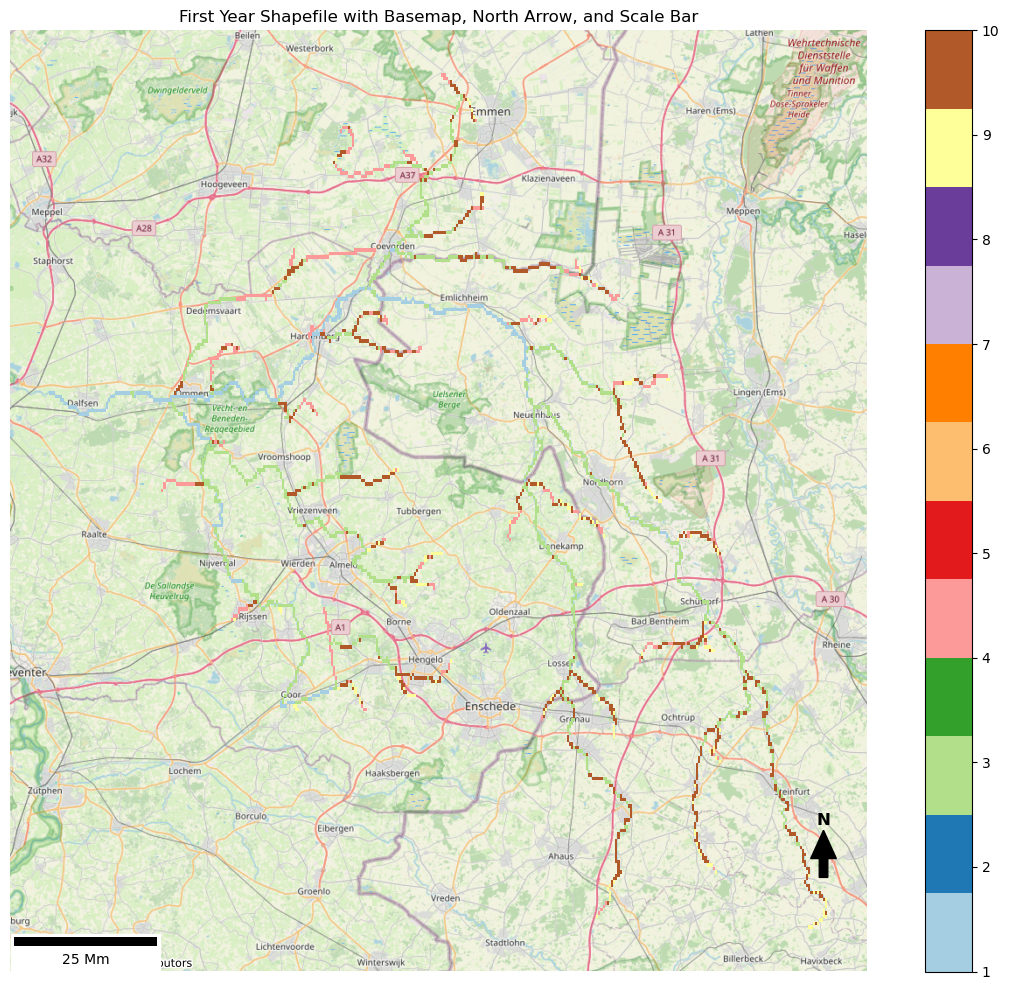

In [23]:

import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib.patches import FancyArrow
from matplotlib_scalebar.scalebar import ScaleBar
import os
import re

output_path = 'example_output_data/shapefile_output_NearBottomFV'

def find_first_year_shapefile(output_path):
    year_to_paths = {}
    for root, _, files in os.walk(output_path):
        for f in files:
            if f.lower().endswith(".shp") and f != "complete_file.shp":
                m = re.search(r"(19|20)\d{2}", f)
                year = int(m.group(0)) if m else None
                if year is None:
                    m2 = re.search(r"(19|20)\d{2}", os.path.basename(root))
                    year = int(m2.group(0)) if m2 else None
                if year is not None:
                    year_to_paths.setdefault(year, []).append(os.path.join(root, f))
    first_year = sorted(year_to_paths.keys())[0]
    return year_to_paths[first_year][0]

shapefile_path = find_first_year_shapefile(output_path)
gdf = gpd.read_file(shapefile_path)
if gdf.crs is None:
    gdf = gdf.set_crs(4326)
gdf = gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(12, 10))
gdf.plot(ax=ax, column='guilds_ADV', cmap='Paired', legend=True)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

arrow = FancyArrow(0.95, 0.1, 0, 0.05, transform=ax.transAxes,
                   width=0.01, head_width=0.03, head_length=0.03,
                   length_includes_head=True, color='black')
ax.add_patch(arrow)
ax.text(0.95, 0.16, 'N', transform=ax.transAxes,
        horizontalalignment='center', verticalalignment='center',
        fontsize=12, fontweight='bold')

scalebar = ScaleBar(dx=1, units="km", dimension="si-length", location='lower left')
ax.add_artist(scalebar)

ax.set_title("First Year Shapefile with Basemap, North Arrow, and Scale Bar")
ax.axis('off')
plt.tight_layout()
plt.show()
